In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
# Download stock price data
stock_symbol = 'AAPL'  # You can change to any stock (e.g., 'TSLA', 'GOOG', etc.)
df = yf.download(stock_symbol, start='2015-01-01', end='2024-12-31')

# Show first few rows
print(df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.320435  24.789804  23.879983  24.778681  212818400
2015-01-05  23.635292  24.169172  23.448435  24.089090  257142000
2015-01-06  23.637508  23.897774  23.274914  23.699794  263188400
2015-01-07  23.968966  24.069067  23.735393  23.846617  160423600
2015-01-08  24.889906  24.947743  24.180291  24.298190  237458000


In [5]:
# Focus only on Close Price
data = df[['Close']].values

# Scale the Close Price between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(scaled_data[:5])  # Preview scaled data

[[0.01531499]
 [0.01243697]
 [0.01244628]
 [0.0138386 ]
 [0.01770711]]


In [6]:
# Train-test split (80% train, 20% test)
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape [samples, time steps, features] for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1952, 60, 1) (1952,)
(443, 60, 1) (443,)


In [7]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Show model summary
model.summary()

C:\Users\SRIJAN DAS\anaconda3\envs\ipl_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 0.0381 - val_loss: 0.0075
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 8.3255e-04 - val_loss: 0.0013
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 3.2693e-04 - val_loss: 8.7866e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 3.3802e-04 - val_loss: 0.0015
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 2.9229e-04 - val_loss: 0.0010
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 2.7184e-04 - val_loss: 0.0019
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 3.0522e-04 - val_loss: 0.0021
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 3.0683e-04 - val_loss: 0.0023
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 2.8504e-04 - val_loss: 0.0017
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 2.3935e-04 - val_loss: 0.0020
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 2.4113e-04 - val_loss: 0.0012
Epoch 12/

In [9]:
# Predict on training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling (convert back to original price)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


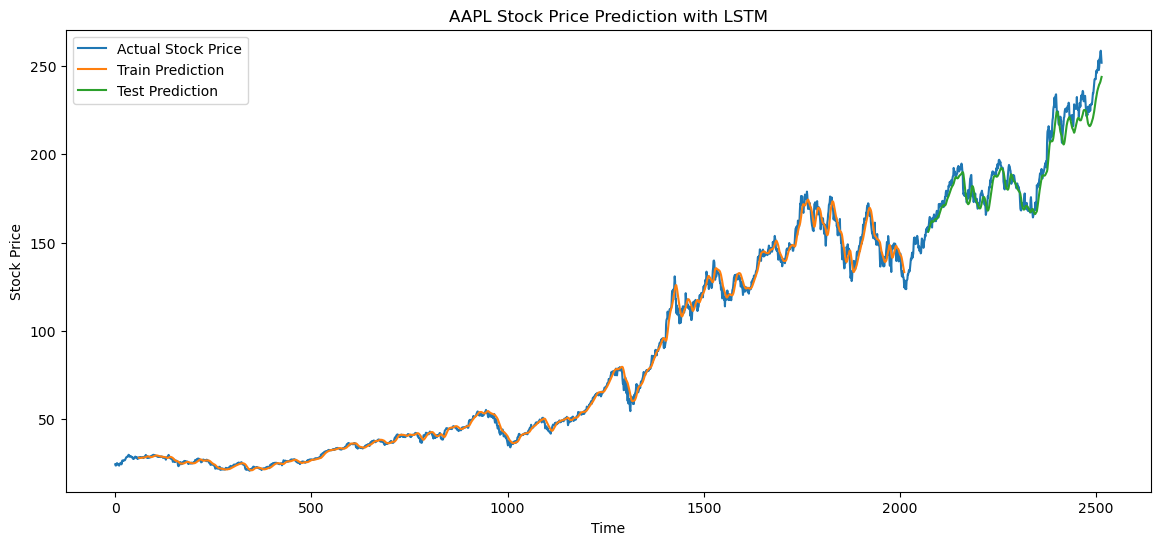

In [10]:
# Plotting
plt.figure(figsize=(14,6))

# Shift train predictions for plotting
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time_step*2):len(scaled_data), :] = test_predict

# Plot actual stock prices
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Price')
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')

plt.title(f"{stock_symbol} Stock Price Prediction with LSTM")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()